
# PySpark NLP

## Objetive

In this exercise, we will perform an NLP analysis on 3.2 million Amazon reviews. Our objective is to tag comments with topics and use a PySpark pipeline (Apache Spark on Python) to parallelize our workload with the MapReduce engine.

You can replicate this code in a linux machine with the following toolbox:

* Data: https://www.kaggle.com/datasets/bittlingmayer/amazonreviews/data
* Java installed (linux in my case):
  - sudo apt update
  - sudo apt install default-jdk
  - check with: hava -version
* Spark installed (again linux in my case):
  - https://towardsdatascience.com/installing-pyspark-with-java-8-on-ubuntu-18-04-6a9dea915b5b
* Spark-nlp library: with pip
* PySpark library: with pip
* Wordcloud library: with pip



In [ ]:
!pip install -q pyspark==3.3.0 spark-nlp==4.2.8
!pip install wordcloud

## Set enviroment

In [ ]:
# Python imports
import sys
import os

# spark-nlp components
from sparknlp.annotator import Stemmer, Tokenizer, Normalizer
from pyspark.ml.feature import StopWordsRemover, CountVectorizer, IDF, SQLTransformer
from sparknlp.base import DocumentAssembler, Finisher
from pyspark.sql import SparkSession
# Datatypes
from pyspark.sql.types import DoubleType
from pyspark.ml import Pipeline
# Clustering
from pyspark.ml.clustering import LDA
# Functions
from pyspark.sql.functions import col, when, regexp_replace, udf
# Visualizations
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from datetime import datetime

#Set JAVA_HOME (you can set it from CMD too)
os.environ['JAVA_HOME']='/home/jupyter/.sdkman/candidates/java/current'

# Build a local PySpark session with your machine specs (in my case, 64 Gb of RAM and 16 cores).
# The "spark.jars.packages" config: Allow PySpark to use SparkNLP jars for processing data.
spark = SparkSession.builder \
    .appName("Spark NLP")\
    .master("local[*]")\
    .config("spark.driver.memory","64g")\
    .config("spark.dynamicAllocation.enabled", False) \
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.0.2")\
    .getOrCreate()

conf = spark.sparkContext.getConf()

spark

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/jupyter/.ivy2/cache
The jars for the packages stored in: /home/jupyter/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-65c01817-c3f9-4655-82fa-2a8db1d9caab;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.0.2 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.20.1 in central
	found com.google.guava#guava;31.1-jre in central
	found com.google.guava#fail

23/10/04 16:19:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Processing pipeline


In this pipeline are the following steps:

* Creating labels column
* DocummentAssembler
* Tokenizing words
* Normalizing
* Stemming
* Removing stop words
* Extracting term frequency (TF)
* Inverse document frequency (IDF)
* LDA Clustering (build topics)
* Create column of most probable topic.

In [ ]:
start = datetime.now() #Processing time

data = spark.read.csv('train.ft.txt.bz2') #Read data

#Split data labels in a new column
data = data.withColumn("label", when(data["_c0"].contains("__label__1"), "1")
                               .when(data["_c0"].contains("__label__2"), "2")
                               .otherwise("0"))

#Delete label string in review text
data = data.withColumn("_c0", regexp_replace(col("_c0"), r"__label__\d+", ""))

# Document assembler for format text for an easier processing
document_assembler = DocumentAssembler().setInputCol("_c0").setOutputCol("document")

# Tokenize words, each word will be an unique string
tokenizer = Tokenizer().setInputCols(["document"]).setOutputCol("token")

# The Normalizer will group words together based on similar semantic meaning.
normalizer = Normalizer().setInputCols(["token"]).setOutputCol("normalizer")

# The Stemmer takes objects of class "Token" and converts the words into their
# root meaning. For instance, the words "cars", "cars'" and "car's" would all be replaced
# with the word "car".
stemmer = Stemmer().setInputCols(["normalizer"]).setOutputCol("stem")

# The Finisher signals to spark-nlp allows us to access the data outside of spark-nlp
# components. For instance, we can now feed the data into components from Spark MLlib.
finisher = Finisher().setInputCols(["stem"]).setOutputCols(["to_spark"]).setValueSplitSymbol(" ")

# Stopwords are common words that generally don't add much detail to the meaning
# of a body of text. In English, these are mostly "articles" such as the words "the"
# and "of".
stopword_remover = StopWordsRemover(inputCol="to_spark", outputCol="filtered")


pre_processing_pipeline = Pipeline(
    stages = [
        document_assembler,
        tokenizer,
        normalizer,
        stemmer,
        finisher,
        stopword_remover
    ]
)

preprocessing_model = pre_processing_pipeline.fit(data)

preprocessed_data = preprocessing_model.transform(data)


#Define topic extraction function
def extract_topics(df):

    # Here we implement TF-IDF as an input to our LDA model. CountVectorizer (TF) keeps track
    # of the vocabulary that's being created so we can map our topics back to their
    # corresponding words.
    # TF (term frequency) creates a matrix that counts how many times each word in the
    # vocabulary appears in each body of text. This then gives each word a weight based
    # on its frequency.
    tf = CountVectorizer(inputCol="filtered", outputCol="raw_features")

    # Here we implement the IDF portion. IDF (Inverse document frequency) reduces
    # the weights of commonly-appearing words.
    idf = IDF(inputCol="raw_features", outputCol="features")

    # LDA measures words frequency of appearing , for build topics
    # We are creating 10 topics for this example
    lda = LDA(k=10, maxIter=10)

    # From our topicDistribution column, extract the highest value
    # That will be our main topic for each review.
    def get_max_topic(topic_distribution):
        return float(topic_distribution.argmax())

    get_max_topic_udf = spark.udf.register("get_max_topic_udf", get_max_topic, DoubleType())

    # Get topic with max score
    sql_transformer = SQLTransformer(
        statement="SELECT *, get_max_topic_udf(topicDistribution) as maxTopic FROM __THIS__"
    )


    # We add all of the transformers into a Pipeline object.
    topic_pipeline = Pipeline(
        stages = [
            tf,
            idf,
            lda,
            sql_transformer
        ]
    )

    # We fit the data to the model.
    topic_model = topic_pipeline.fit(df)

    # Now that we have completed a pipeline, we want to output the topics as human-readable.
    # To do this, we need to grab the vocabulary generated from our pipeline, grab the topic
    # model and do the appropriate mapping.  The output from each individual component lives
    # in the model object. We can access them by referring to them by their position in
    # the pipeline via model.stages[<ind>]

    # Let's create a reference our vocabulary.
    # Get the "tf" stage and extract vocabulary
    vocab = topic_model.stages[-4].vocabulary
    #Get topics
    raw_topics = topic_model.stages[-2].describeTopics().collect()

    #Get most frequent words in each topic
    topic_inds = [ind.termIndices for ind in raw_topics]

    # The indices we just grab directly map to the term at position <ind> from our vocabulary.
    # Using the below code, we can generate the mappings from our topic indices to our vocabulary.
    topics = []
    for topic in topic_inds:
        _topic = []
        for ind in topic:
            _topic.append(vocab[ind])
        topics.append(_topic)

    # Let's see our topics!
    for i, topic in enumerate(topics, start=0):
        print(f"topic {i}: {topic}")

    results = topic_model.transform(df)

    # Show results
    results.show()

    return results

good_results = extract_topics(preprocessed_data.filter(data.label == "2")) #topics for good reviews
print(datetime.now() - start) #Print execution time for good reviews

bad_results = extract_topics(preprocessed_data.filter(data.label == "1")) #Topics for bad reviews

print(datetime.now() - start) # Print execution time for bad reviews

23/10/04 16:38:23 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


23/10/04 16:40:25 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


23/10/04 16:40:26 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


23/10/04 16:42:29 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
23/10/04 16:42:31 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
23/10/04 16:42:32 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
23/10/04 16:42:32 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/10/04 16:42:32 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


23/10/04 16:42:38 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


23/10/04 16:42:39 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
23/10/04 16:42:39 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


23/10/04 16:42:43 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


23/10/04 16:42:43 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
23/10/04 16:42:44 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


23/10/04 16:42:46 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


23/10/04 16:42:46 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
23/10/04 16:42:47 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


23/10/04 16:42:50 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


23/10/04 16:42:50 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
23/10/04 16:42:51 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


23/10/04 16:42:53 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


23/10/04 16:42:53 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
23/10/04 16:42:54 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


23/10/04 16:42:56 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


23/10/04 16:42:56 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
23/10/04 16:42:57 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


23/10/04 16:42:59 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


23/10/04 16:42:59 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
23/10/04 16:43:00 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


23/10/04 16:43:02 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


23/10/04 16:43:02 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
23/10/04 16:43:03 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


23/10/04 16:43:05 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


23/10/04 16:43:05 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
23/10/04 16:43:06 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


23/10/04 16:43:08 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


topic 0: ['book', 'read', 'thi', 'wa', 'hi', 'veri', 'stori', 'ar', 'excel', 'movi']
topic 1: ['movi', 'music', 'thi', 'wa', 'book', 'best', 'good', 'film', 'great', 'album']
topic 2: ['game', 'movi', 'fun', 'love', 'great', 'thi', 'cd', 'ar', 'toi', 'wa']
topic 3: ['wa', 'thi', 'great', 'love', 'us', 'veri', 'good', 'product', 'thei', 'bought']
topic 4: ['album', 'cd', 'wa', 'thi', 'song', 'great', 'book', 'rock', 'ar', 'good']
topic 5: ['book', 'read', 'stori', 'thi', 'wa', 'great', 'love', 'ar', 'life', 'wonder']
topic 6: ['good', 'great', 'thi', 'movi', 'wa', 'nice', 'book', 'ar', 'veri', 'well']
topic 7: ['workout', 'thi', 'book', 'great', 'veri', 'us', 'wa', 'work', 'love', 'good']
topic 8: ['book', 'food', 'wa', 'great', 'thi', 'us', 'good', 'ic', 'ar', 'pen']
topic 9: ['work', 'us', 'great', 'product', 'thi', 'veri', 'good', 'easi', 'camera', 'wa']
23/10/04 16:43:11 WARN DAGScheduler: Broadcasting large task binary with size 26.9 MiB


+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------+
|                 _c0|label|            to_spark|            filtered|        raw_features|            features|   topicDistribution|maxTopic|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------+
| Stuning even for...|    2|[stune, even, for...|[stune, even, non...|(262144,[0,3,11,1...|(262144,[0,3,11,1...|[4.10175214415583...|     2.0|
| The best soundtr...|    2|[the, best, sound...|[best, soundtrack...|(262144,[0,8,11,1...|(262144,[0,8,11,1...|[4.81112989547098...|     1.0|
| Amazing!: This s...|    2|[amaz, thi, sound...|[amaz, thi, sound...|(262144,[0,14,32,...|(262144,[0,14,32,...|[0.00470206426022...|     1.0|
| Excellent Soundt...|    2|[excel, soundtrac...|[excel, soundtrac...|(262144,[0,6,9,14...|(262144,[0,6,9,14...|[0.00110189693626...|     2.0|

23/10/04 16:45:22 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


23/10/04 16:47:28 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


23/10/04 16:47:28 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


23/10/04 16:49:35 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
23/10/04 16:49:35 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
23/10/04 16:49:36 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


23/10/04 16:49:42 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


23/10/04 16:49:42 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
23/10/04 16:49:43 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


23/10/04 16:49:46 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


23/10/04 16:49:46 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
23/10/04 16:49:47 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


23/10/04 16:49:49 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


23/10/04 16:49:50 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
23/10/04 16:49:51 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


23/10/04 16:49:53 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


23/10/04 16:49:53 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
23/10/04 16:49:54 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


23/10/04 16:49:57 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


23/10/04 16:49:57 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
23/10/04 16:49:58 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


23/10/04 16:50:00 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


23/10/04 16:50:00 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
23/10/04 16:50:01 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


23/10/04 16:50:03 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


23/10/04 16:50:03 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
23/10/04 16:50:04 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


23/10/04 16:50:06 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


23/10/04 16:50:06 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
23/10/04 16:50:07 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


23/10/04 16:50:09 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


23/10/04 16:50:09 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
23/10/04 16:50:10 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


23/10/04 16:50:12 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


topic 0: ['cd', 'album', 'song', 'dvd', 'thi', 'wa', 'like', 'ar', 'music', 'thei']
topic 1: ['game', 'wa', 'thi', 'film', 'movi', 'good', 'sound', 'ar', 'like', 'music']
topic 2: ['book', 'read', 'wa', 'thi', 'bore', 'hi', 'stori', 'dont', 'like', 'good']
topic 3: ['product', 'wa', 'us', 'thi', 'work', 'thei', 'veri', 'get', 'item', 'batteri']
topic 4: ['book', 'wa', 'thi', 'read', 'ar', 'movi', 'veri', 'review', 'thei', 'good']
topic 5: ['movi', 'book', 'wa', 'thi', 'ar', 'stori', 'bad', 'worst', 'ever', 'read']
topic 6: ['thi', 'wa', 'bui', 'drive', 'product', 'dont', 'bad', 'book', 'mac', 'dvd']
topic 7: ['work', 'month', 'us', 'thi', 'phone', 'toi', 'window', 'wa', 'product', 'broke']
topic 8: ['leak', 'wa', 'thi', 'us', 'bag', 'bought', 'year', 'ok', 'hair', 'product']
topic 9: ['wa', 'us', 'thi', 'work', 'product', 'defect', 'thei', 'week', 'time', 'month']
23/10/04 16:50:15 WARN DAGScheduler: Broadcasting large task binary with size 27.0 MiB


+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------+
|                 _c0|label|            to_spark|            filtered|        raw_features|            features|   topicDistribution|maxTopic|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------+
| Buyer beware: Th...|    1|[buyer, bewar, th...|[buyer, bewar, th...|(262144,[0,2,275,...|(262144,[0,2,275,...|[0.00420726197109...|     4.0|
| The Worst!: A co...|    1|[the, worst, a, c...|[worst, complet, ...|(262144,[15,30,59...|(262144,[15,30,59...|[0.00336400918528...|     2.0|
| Oh please: I gue...|    1|[oh, pleas, i, gu...|[oh, pleas, guess...|(262144,[0,210,25...|(262144,[0,210,25...|[0.00282415954093...|     2.0|
| Awful beyond bel...|    1|[aw, beyond, beli...|[aw, beyond, beli...|(262144,[0,2,23,2...|(262144,[0,2,23,2...|[0.00100452760467...|     2.0|

In [ ]:
# Show comments per topic

def show_topics_grouped(results):
    pivot_table = results.groupBy("maxTopic").agg({"_c0": "count"})
    pivot_table = pivot_table.orderBy("maxTopic")
    return pivot_table.show()

show_topics_grouped(good_results) #Good topics
show_topics_grouped(bad_results) #Bad topics

23/10/04 16:50:21 WARN DAGScheduler: Broadcasting large task binary with size 26.9 MiB


23/10/04 16:52:57 WARN DAGScheduler: Broadcasting large task binary with size 26.9 MiB
+--------+----------+
|maxTopic|count(_c0)|
+--------+----------+
|     0.0|    283383|
|     1.0|    168646|
|     2.0|    213833|
|     3.0|    321662|
|     4.0|    193300|
|     5.0|    190844|
|     6.0|     63909|
|     7.0|     94024|
|     8.0|     57099|
|     9.0|    213300|
+--------+----------+



23/10/04 16:52:57 WARN DAGScheduler: Broadcasting large task binary with size 26.9 MiB


23/10/04 16:55:31 WARN DAGScheduler: Broadcasting large task binary with size 26.9 MiB
+--------+----------+
|maxTopic|count(_c0)|
+--------+----------+
|     0.0|    186560|
|     1.0|    142342|
|     2.0|    263798|
|     3.0|    421948|
|     4.0|    161930|
|     5.0|    279442|
|     6.0|     56893|
|     7.0|    118622|
|     8.0|     69419|
|     9.0|     99046|
+--------+----------+



## Review topics in a word cloud

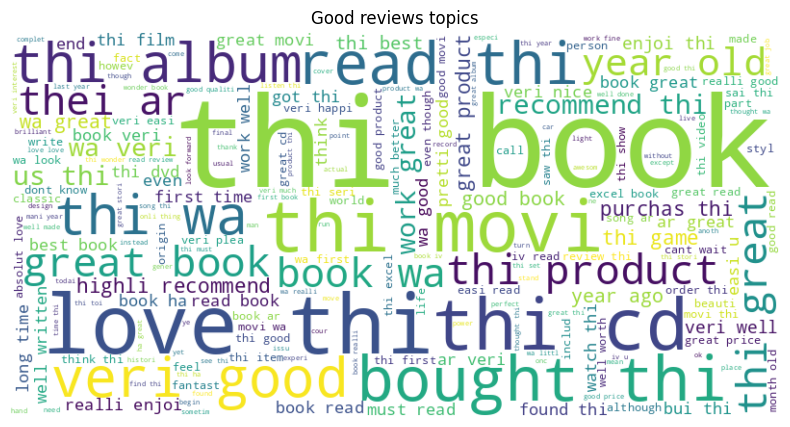

In [ ]:
#Good reviews word plot
text_data = good_results.select("filtered").rdd.flatMap(lambda x: x).collect()

text_data_flat = [item.strip() for sublist in text_data for item in sublist]

# Join all texts
text_combined = " ".join(text_data_flat)

# Generate wordcloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_combined)

# Show wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Good reviews topics")
plt.show()

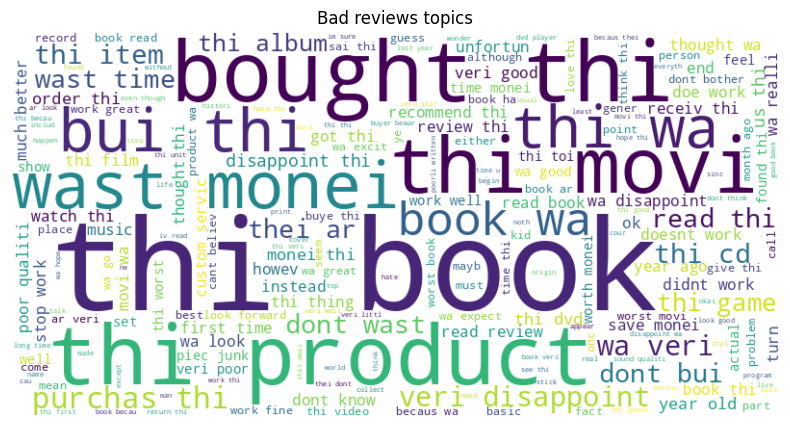

In [ ]:
#Bad reviews word plot
text_data = bad_results.select("filtered").rdd.flatMap(lambda x: x).collect()

text_data_flat = [item.strip() for sublist in text_data for item in sublist]

# Join strings
text_combined = " ".join(text_data_flat)

# Generate wordcloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_combined)

#show wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Bad reviews topics")
plt.show()


In [ ]:
#Save good reviews results in local memory
good_results.select('_c0', 'label', 'maxTopic').write.option("compression", "snappy").mode("overwrite").parquet("/home/jupyter/good_results")

23/10/04 17:18:47 WARN DAGScheduler: Broadcasting large task binary with size 27.1 MiB


In [ ]:
#Save bad reviews results in local memory
bad_results.select('_c0', 'label', 'maxTopic').write.option("compression", "snappy").mode("overwrite").parquet("/home/jupyter/bad_results")

23/10/04 17:21:23 WARN DAGScheduler: Broadcasting large task binary with size 27.2 MiB


## What can we do with topics?

Now we can rename the topics in order to add readability, in example, for good reviews topics:

* topic 0 (Good books-movies): ['book', 'read', 'thi', 'wa', 'hi', 'veri', 'stori', 'ar', 'excel', 'movi']
* topic 1 (Good music-movies): ['movi', 'music', 'thi', 'wa', 'book', 'best', 'good', 'film', 'great', 'album']
* topic 3 (Great products): ['wa', 'thi', 'great', 'love', 'us', 'veri', 'good', 'product', 'thei', 'bought']
* topic 5 (Wonderful stories): ['book', 'read', 'stori', 'thi', 'wa', 'great', 'love', 'ar', 'life', 'wonder']
* topic 8 (Great food-books): ['book', 'food', 'wa', 'great', 'thi', 'us', 'good', 'ic', 'ar', 'pen']
* topic 9 (Great products): ['work', 'us', 'great', 'product', 'thi', 'veri', 'good', 'easi', 'camera', 'wa']

for bad reviews topics:

* topic 0 (bad music-albums): ['cd', 'album', 'song', 'dvd', 'thi', 'wa', 'like', 'ar', 'music', 'thei']
* topic 1 (bad games-movies): ['game', 'wa', 'thi', 'film', 'movi', 'good', 'sound', 'ar', 'like', 'music']
* topic 3 (useless products): ['product', 'wa', 'us', 'thi', 'work', 'thei', 'veri', 'get', 'item', 'batteri']
* topic 4 (bad books - movies): ['book', 'wa', 'thi', 'read', 'ar', 'movi', 'veri', 'review', 'thei', 'good']
* topic 5 (worst stories): ['movi', 'book', 'wa', 'thi', 'ar', 'stori', 'bad', 'worst', 'ever', 'read']
* topic 7 (bad toys-phones): ['work', 'month', 'us', 'thi', 'phone', 'toi', 'window', 'wa', 'product', 'broke']
* topic 8 (bad hair products): ['leak', 'wa', 'thi', 'us', 'bag', 'bought', 'year', 'ok', 'hair', 'product']



## Next steps

With the topic already in our data, we can segment reviews and perform different analyses such as:

* Performing Aspect-Based Sentiment Analysis (ABSA) in order to find specific reasons for a good or bad review in each category.

* Generating a report with the principal failures in each category and prescriptive actions.

* Provide feedback to product sellers about the good and bad aspects associated with their products (topics).

## Conclusions

With this NLP analysis, we can label and identify topics in comments, reviews, or other types of texts. This is useful for clustering comments by categories and, in this particular case, identifying reasons for a good or bad review.

We have taken advantage of PySpark's parallelism on 16 cores. It allows us to analyze 3.2M rows of reviews in 14 minutes, with the possibility of horizontal scaling for faster processing in a machine's cluster (like Google Cloud Dataproc). Here is a picture showing the partition processing of one step in the PySpark cluster, each green bar is the processing time for each core (only the fourth core is slightly underbalanced in data):

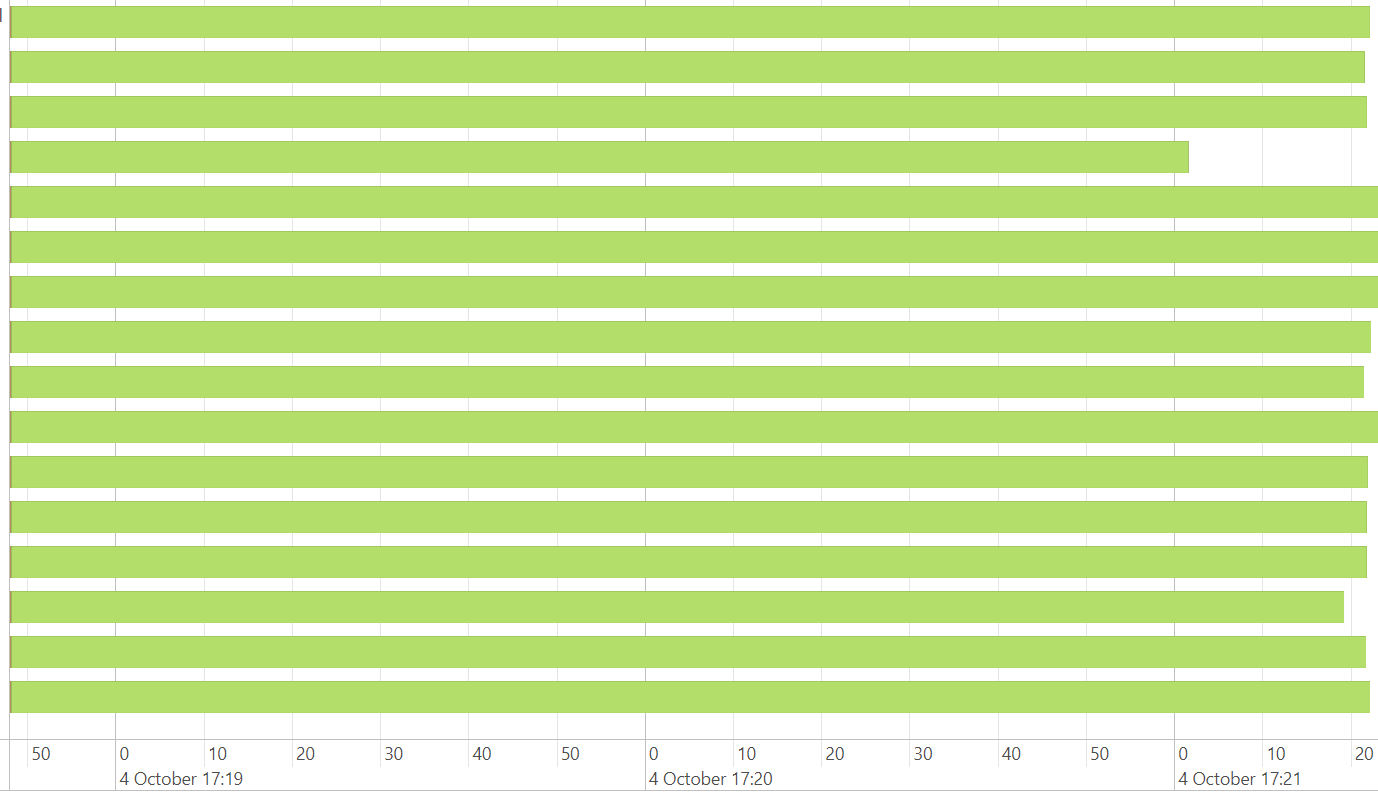